## RetinaNet

<br>

### preparation

- toy dataset: [FDDB: Face Detection Data Set and Benchmark](http://vis-www.cs.umass.edu/fddb/)

- run the script(ellipsis_to_rectangle.py) to convert annotations in ellipsis to rectangle

## Construct Dataset

In [3]:
import os
import numpy as np
import cv2
from cv2 import imread, resize, imwrite
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import glob
import json
from datasets.utils import anchor_targets_bbox, bbox_transform, anchors_for_shape

In [4]:
IM_EXTENSIONS = ['png', 'jpg', 'bmp']

def load_json(json_path):
    """
    Load json file
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    return data

def get_best_anchor(anchors, box_wh):
    """
    Select the best anchor with highest IOU
    """
    box_wh = np.array(box_wh)
    best_iou = 0
    best_anchor = 0
    for k, anchor in enumerate(anchors):
        intersect_wh = np.maximum(np.minimum(box_wh, anchor), 0.0)
        intersect_area = intersect_wh[0] * intersect_wh[1]
        box_area = box_wh[0] * box_wh[1]
        anchor_area = anchor[0] * anchor[1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)
        if iou > best_iou:
            best_iou = iou
            best_anchor = k
    return best_anchor

In [5]:
def read_data(data_dir, image_size, no_label=False):
    """
    Load the data and preprocessing for RetinaNet detector
    :param data_dir: str, path to the directory to read.
                     It should include class_map, annotations
    :image_size: tuple, image size for resizing images
    :no_label: bool, whetehr to load labels
    :return: X_set: np.ndarray, shape: (N, H, W, C).
             y_set: np.ndarray, shape: (N, N_box, 5+num_classes).
    """
    im_dir = os.path.join(data_dir, 'images')
    class_map_path = os.path.join(data_dir, 'classes.json')
    class_map = load_json(class_map_path)
    anchors = anchors_for_shape(image_size)
    num_classes = len(class_map)
    ih, iw = image_size
    im_paths = []
    for ext in IM_EXTENSIONS:
        im_paths.extend(glob.glob(os.path.join(im_dir, '*.{}'.format(ext))))
    anno_dir = os.path.join(data_dir, 'annotations')
    images = []
    labels = []

    for im_path in im_paths:
        # load image and resize image
        im = imread(im_path)
        im = np.array(im, dtype=np.float32)
        im_original_sizes = im.shape[:2]
        im = resize(im, (image_size[1], image_size[0]))
        if len(im.shape) == 2:
            im = np.expand_dims(im, 2)
            im = np.concatenate([im, im, im], -1)
        images.append(im)

        if no_label:
            labels.append(0)
            continue
        # load bboxes and reshape for retina model
        name = os.path.splitext(os.path.basename(im_path))[0]
        anno_path = os.path.join(anno_dir, '{}.anno'.format(name))
        anno = load_json(anno_path)
        bboxes = []

        for c_idx, c_name in class_map.items():
            if c_name not in anno:
                continue
            for x_min, y_min, x_max, y_max in anno[c_name]:
                oh, ow = im_original_sizes
                x_min, y_min, x_max, y_max = x_min / ow, y_min / oh, x_max/ ow, y_max / oh
                bboxes.append([x_min, y_min, x_max, y_max, int(c_idx)+1])
            bboxes = np.array(bboxes)
            bboxes = np.array([iw, ih, iw, ih, 1], dtype=np.float32) * bboxes

            b_labels, annotations = anchor_targets_bbox(im.shape, bboxes, num_classes + 1, anchors)
            regression = bbox_transform(anchors, annotations)
            label = np.array(np.append(regression, b_labels, axis=1), dtype=np.float32)
        labels.append(label)

    X_set = np.array(images, dtype=np.float32)
    y_set = np.array(labels, dtype=np.float32)

    return X_set, y_set

In [6]:
class DataSet(object):

    def __init__(self, images, labels=None):
        """
        Construct a new DataSet object.
        :param images: np.ndarray, shape: (N, H, W, C)
        :param labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes).
        """
        if labels is not None:
            assert images.shape[0] == labels.shape[0],\
                ('Number of examples mismatch, between images and labels')
        self._num_examples = images.shape[0]
        self._images = images
        self._labels = labels  # NOTE: this can be None, if not given.
        # image/label indices(can be permuted)
        self._indices = np.arange(self._num_examples, dtype=np.uint)
        self._reset()

    def _reset(self):
        """Reset some variables."""
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    def sample_batch(self, batch_size, shuffle=True):
        """
        Return sample examples from this dataset.
        :param batch_size: int, size of a sample batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        if shuffle:
            indices = np.random.choice(self._num_examples, batch_size)
        else:
            indices = np.arange(batch_size)
        batch_images = self._images[indices]
        if self._labels is not None:
            batch_labels = self._labels[indices]
        else:
            batch_labels = None
        return batch_images, batch_labels

    def next_batch(self, batch_size, shuffle=True):
        """
        Return the next 'batch_size' examples from this dataset.
        :param batch_size: int, size of a single batch.
        :param shuffle: bool, whether to shuffle the whole set while sampling a batch.
        :return: batch_images: np.ndarray, shape: (N, H, W, C)
                 batch_labels: np.ndarray, shape: (N, g_H, g_W, anchors, 5 + num_classes)
        """

        start_index = self._index_in_epoch

        # Shuffle the dataset, for the first epoch
        if self._epochs_completed == 0 and start_index == 0 and shuffle:
            np.random.shuffle(self._indices)

        # Go to the next epoch, if current index goes beyond the total number
        # of examples
        if start_index + batch_size > self._num_examples:
            # Increment the number of epochs completed
            self._epochs_completed += 1
            # Get the rest examples in this epoch
            rest_num_examples = self._num_examples - start_index
            indices_rest_part = self._indices[start_index:self._num_examples]

            # Shuffle the dataset, after finishing a single epoch
            if shuffle:
                np.random.shuffle(self._indices)

            # Start the next epoch
            start_index = 0
            self._index_in_epoch = batch_size - rest_num_examples
            end_index = self._index_in_epoch
            indices_new_part = self._indices[start_index:end_index]

            images_rest_part = self._images[indices_rest_part]
            images_new_part = self._images[indices_new_part]
            batch_images = np.concatenate(
                (images_rest_part, images_new_part), axis=0)
            if self._labels is not None:
                labels_rest_part = self._labels[indices_rest_part]
                labels_new_part = self._labels[indices_new_part]
                batch_labels = np.concatenate(
                    (labels_rest_part, labels_new_part), axis=0)
            else:
                batch_labels = None
        else:
            self._index_in_epoch += batch_size
            end_index = self._index_in_epoch
            indices = self._indices[start_index:end_index]
            batch_images = self._images[indices]
            if self._labels is not None:
                batch_labels = self._labels[indices]
            else:
                batch_labels = None

        return batch_images, batch_labels

In [7]:
# set paths
root_dir = os.path.join('data/face/')
trainval_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
class_map = load_json(os.path.join(trainval_dir, 'classes.json'))

# set hyperparameters for data
IM_SIZE = (512, 512)
NUM_CLASSES = 1
VALID_RATIO = 0.1

In [8]:
X_trainval, y_trainval = read_data(trainval_dir, IM_SIZE)
trainval_size = X_trainval.shape[0]
val_size = int(trainval_size * VALID_RATIO)
val_set = DataSet(X_trainval[:val_size], y_trainval[:val_size])
train_set = DataSet(X_trainval[val_size:], y_trainval[val_size:])

In [9]:
X_test, y_test = read_data(test_dir, IM_SIZE)
test_set = DataSet(X_test, y_test)

## Construct Network

In [10]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import resnet_v2 as resnet_v2
slim = tf.contrib.slim

In [11]:
def conv_layer(x, filters, kernel_size, strides, padding='SAME', use_bias=True):
    return tf.layers.conv2d(x, filters, kernel_size, strides, padding, use_bias=use_bias)

def build_head_loc(x, num_anchors, depth=4, name='head_loc'):
    head = x
    with tf.variable_scope(name):
        for _ in range(depth):
            head = tf.nn.relu(conv_layer(head, 256, (3, 3), (1, 1)))
        output_channels = num_anchors * 4
        head = conv_layer(head, output_channels, (3, 3), (1, 1))
    return head

def build_head_cls(x, num_anchors, num_classes, depth=4, prior_probs=0.01, name='head_cls'):
    head = x
    with tf.variable_scope(name):
        for _ in range(depth):
            head = tf.nn.relu(conv_layer(head, 256, (3, 3), (1, 1)))
        output_channels = num_anchors * num_classes
        bias = np.zeros((num_classes, 1, 1), dtype=np.float32)
        bias[0] = np.log((num_classes - 1) * (1 - prior_probs) / (prior_probs))
        bias = np.vstack([bias for _ in range(num_anchors)])
        biases = tf.get_variable('biases', [num_anchors * num_classes], tf.float32,\
                                tf.constant_initializer(value=bias))
        head = conv_layer(head, output_channels, (3, 3), (1, 1), use_bias=False) + biases
    return head

def resize_to_target(x, target):
    size = (tf.shape(target)[1], tf.shape(target)[2])
    x = tf.image.resize_bilinear(x, size)
    return tf.cast(x, x.dtype)

In [12]:
input_shape = list(IM_SIZE) + [3]
num_classes = NUM_CLASSES
anchors = anchors_for_shape(input_shape[:2])
num_anchors = 9

# Prepare Input
X = tf.placeholder(tf.float32, [None] + input_shape)
y = tf.placeholder(tf.float32, [None] + [anchors.shape[0]] + [5 + num_classes])
is_train = tf.placeholder(tf.bool)

In [13]:
# init build graph
graph = tf.get_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [14]:
d = dict()
frontend = 'resnet_v2_50'

with slim.arg_scope(resnet_v2.resnet_arg_scope()):
    frontend_dir = os.path.join('pretrained_models', '{}.ckpt'.format(frontend))
    logits, end_points = resnet_v2.resnet_v2_50(X, is_training=is_train)
    d['init_fn'] = slim.assign_from_checkpoint_fn(model_path=frontend_dir,
                                              var_list=slim.get_model_variables(frontend))
convs = [end_points[frontend + '/block{}'.format(x)] for x in [4, 2, 1]]

with tf.variable_scope('layer5'):
    d['s_5'] = conv_layer(convs[0], 256, (1, 1), (1, 1))
    d['cls_head5'] = build_head_cls(d['s_5'], num_anchors, num_classes + 1)
    d['loc_head5'] = build_head_loc(d['s_5'], num_anchors)
    d['flat_cls_head5'] = tf.reshape(d['cls_head5'], (tf.shape(d['cls_head5'])[0], -1, num_classes + 1))
    d['flat_loc_head5'] = tf.reshape(d['loc_head5'], (tf.shape(d['loc_head5'])[0], -1, 4))

with tf.variable_scope('layer6'):
    d['s_6'] = conv_layer(d['s_5'], 256, (3, 3), (2, 2))
    d['cls_head6'] = build_head_cls(d['s_6'], num_anchors, num_classes + 1)
    d['loc_head6'] = build_head_loc(d['s_6'], num_anchors)
    d['flat_cls_head6'] = tf.reshape(d['cls_head6'], (tf.shape(d['cls_head6'])[0], -1, num_classes + 1))
    d['flat_loc_head6'] = tf.reshape(d['loc_head6'], (tf.shape(d['loc_head6'])[0], -1, 4))

with tf.variable_scope('layer7'):
    d['s_7'] = conv_layer(tf.nn.relu(d['s_6']), 256, (3, 3), (2, 2))
    d['cls_head7'] = build_head_cls(d['s_7'], num_anchors, num_classes + 1)
    d['loc_head7'] = build_head_loc(d['s_7'], num_anchors)
    d['flat_cls_head7'] = tf.reshape(d['cls_head7'], (tf.shape(d['cls_head7'])[0], -1, num_classes + 1))
    d['flat_loc_head7'] = tf.reshape(d['loc_head7'], (tf.shape(d['loc_head7'])[0], -1, 4))

with tf.variable_scope('layer4'):
    d['up4'] = resize_to_target(d['s_5'], convs[1])
    d['s_4'] = conv_layer(convs[1], 256, (1, 1), (1, 1)) + d['up4']
    d['cls_head4'] = build_head_cls(d['s_4'], num_anchors, num_classes + 1)
    d['loc_head4'] = build_head_loc(d['s_4'], num_anchors)
    d['flat_cls_head4'] = tf.reshape(d['cls_head4'], (tf.shape(d['cls_head4'])[0], -1, num_classes + 1))
    d['flat_loc_head4'] = tf.reshape(d['loc_head4'], (tf.shape(d['loc_head4'])[0], -1, 4))

with tf.variable_scope('layer3'):
    d['up3'] = resize_to_target(d['s_4'], convs[2])
    d['s_3'] = conv_layer(convs[2], 256, (1, 1), (1, 1)) + d['up3']
    d['cls_head3'] = build_head_cls(d['s_3'], num_anchors, num_classes + 1)
    d['loc_head3'] = build_head_loc(d['s_3'], num_anchors)
    d['flat_cls_head3'] = tf.reshape(d['cls_head3'], (tf.shape(d['cls_head3'])[0], -1, num_classes + 1))
    d['flat_loc_head3'] = tf.reshape(d['loc_head3'], (tf.shape(d['loc_head3'])[0], -1, 4))

with tf.variable_scope('head'):
    d['cls_head'] = tf.concat((d['flat_cls_head3'],
                               d['flat_cls_head4'],
                               d['flat_cls_head5'],
                               d['flat_cls_head6'],
                               d['flat_cls_head7']), axis=1)

    d['loc_head'] = tf.concat((d['flat_loc_head3'],
                               d['flat_loc_head4'],
                               d['flat_loc_head5'],
                               d['flat_loc_head6'],
                               d['flat_loc_head7']), axis=1)

    d['logits'] = tf.concat((d['loc_head'], d['cls_head']), axis=2)
    d['pred'] = tf.concat((d['loc_head'], tf.nn.softmax(d['cls_head'], axis=-1)), axis=2)

In [26]:
logits = d['logits']
pred = d['pred']
pred_y = pred

## Build Loss

In [16]:
def focal_loss(y_pred, y_true, alpha=0.25, gamma=2.0):
    with tf.variable_scope('focal_loss'):
        y_true, y_pred = [x[:, :, 4:] for x in [y_true, y_pred]]

        total_state = tf.reduce_max(y_true, axis=-1, keepdims=True)
        total_state = tf.cast(tf.math.equal(total_state, 1), dtype=tf.float32)
        pos_state = tf.reduce_max(y_true[..., 1:], axis=-1, keepdims=True)
        pos_state = tf.cast(tf.math.equal(pos_state, 1), dtype=tf.float32)
        divisor = tf.reduce_sum(pos_state)
        divisor = tf.clip_by_value(divisor, 1, divisor)

        labels = tf.multiply(total_state, y_true)
        class_logits = tf.multiply(total_state, y_pred)
        class_probs = tf.nn.softmax(class_logits, axis=-1)
        focal_weight = alpha * tf.pow((1-class_probs), gamma)
        mask_focal_weight = tf.multiply(labels, focal_weight)
        mask_focal_weight = tf.reduce_max(mask_focal_weight, axis=-1, keepdims=True)
        entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=class_logits)
        entropy = tf.expand_dims(entropy, axis=-1)
        focal_loss = mask_focal_weight * entropy
        focal_loss = tf.reduce_sum((focal_loss / divisor))
    return focal_loss

def smooth_l1_loss(y_pred, y_true, sigma=3.0):
    sigma2 = sigma * sigma
    with tf.variable_scope('smooth_l1_loss'):
        anchor_state = tf.reduce_max(y_true[:, :, 5:], axis=-1, keepdims=True)
        y_true, y_pred = [x[:, :, :4] for x in [y_true, y_pred]]

        regression = y_pred
        regression_target = y_true[:, :, :4]
        pos_state = tf.cast(tf.math.equal(anchor_state, 1), dtype=tf.float32)
        divisor = tf.reduce_sum(pos_state)
        divisor = tf.clip_by_value(divisor, 1, divisor)

        abs_loss = tf.abs(tf.multiply(pos_state, (regression-regression_target)))

        smooth_l1_sign = tf.cast(tf.less(abs_loss, 1.0/sigma2), dtype=tf.float32)
        smooth_l1_option1 = tf.multiply(tf.pow(abs_loss, 2), 0.5*sigma2)
        smooth_l1_option2 = abs_loss - (0.5/sigma2)
        smooth_l1_results = tf.multiply(smooth_l1_option1, smooth_l1_sign) + \
                            tf.multiply(smooth_l1_option2, (1 - smooth_l1_sign))
        smooth_l1_results = tf.reduce_sum((smooth_l1_results / divisor))
    return smooth_l1_results

In [17]:
r_alpha = 1
with tf.variable_scope('losses'):
    conf_loss = focal_loss(logits, y)
    regress_loss = smooth_l1_loss(logits, y)
    total_loss = conf_loss + r_alpha * regress_loss

## Training Session

In [18]:
from learning.utils import get_boxes, cal_recall

In [19]:
def score(y_true, y_pred, anchors):
    """Compute Recall for a given predicted bboxes"""
    bboxes = get_boxes(y_pred, anchors, gt=False)
    gt_bboxes = get_boxes(y_true, anchors)
    score = cal_recall(gt_bboxes, bboxes)
    return score

def predict(sess, dataset, **kwargs):
    batch_size = kwargs.pop('batch_size', 16)
    pred_size = dataset.num_examples
    num_steps = pred_size // batch_size
    flag = int(bool(pred_size % batch_size))
    # Start prediction loop
    _y_pred = []
    for i in range(num_steps + flag):
        if i == num_steps and flag:
            _batch_size = pred_size - num_steps * batch_size
        else:
            _batch_size = batch_size
        X_true, _ = dataset.next_batch(_batch_size, shuffle=False)

        # Compute predictions
        y_pred = sess.run(pred_y, feed_dict={
                          X: X_true, is_train: False})

        _y_pred.append(y_pred)
    _y_pred = np.concatenate(_y_pred, axis=0)
    return _y_pred

In [20]:
sess = tf.Session(graph=graph, config=config)
saver = tf.train.Saver()

In [21]:
# Set hyperparameters for training
batch_size = 2
num_epochs = 5
learning_rate = 1e-4
eps = 1e-3
num_eval = 128

In [22]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
update_vars = tf.trainable_variables()
with tf.control_dependencies(extra_update_ops):
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).\
                minimize(total_loss, var_list=update_vars)

In [23]:
sess.run(tf.global_variables_initializer())

In [24]:
train_size = train_set.num_examples
num_steps_per_epoch = train_size // batch_size
num_steps = num_epochs * num_steps_per_epoch

In [ ]:
curr_epoch = 1
best_score = 0
curr_score = 0
# Start training loop
for i in range(num_steps):
    X_true, y_true = train_set.next_batch(batch_size, shuffle=True)
    _, loss, y_pred = sess.run([train_op, total_loss, pred_y],
                              feed_dict={X:X_true, y: y_true, is_train: True})
    if (i+1) % num_eval == 0:
        step_score = score(y_true, y_pred, anchors)
        eval_y_pred = predict(sess, val_set)
        eval_score = score(val_set.labels, eval_y_pred, anchors)
        print('[epoch {}]\tloss: {:.6f} |Train score: {:.6f} |Eval score: {:.6f}'
      .format(curr_epoch, loss, step_score, eval_score))
        curr_score = eval_score

    if curr_score > best_score + eps:
        best_score = curr_score
        saver.save(sess, './retina.ckpt')
        
    if (i+1) % num_steps_per_epoch == 0:
        curr_epoch += 1

[epoch 1]	loss: 3.802230 |Train score: 0.500000 |Eval score: 0.144654
[epoch 1]	loss: 3.431743 |Train score: 0.200000 |Eval score: 0.081761
[epoch 1]	loss: 3.571404 |Train score: 1.000000 |Eval score: 0.408805
[epoch 1]	loss: 2.587656 |Train score: 1.000000 |Eval score: 0.452830
[epoch 1]	loss: 3.596600 |Train score: 0.166667 |Eval score: 0.561845
[epoch 1]	loss: 3.781078 |Train score: 0.750000 |Eval score: 0.545073
[epoch 1]	loss: 3.644810 |Train score: 0.200000 |Eval score: 0.547170
[epoch 1]	loss: 2.123563 |Train score: 1.000000 |Eval score: 0.570231
[epoch 1]	loss: 1.713469 |Train score: 1.000000 |Eval score: 0.607966
[epoch 2]	loss: 1.552583 |Train score: 0.666667 |Eval score: 0.566038


## Test image and draw bboxes

In [31]:
from utils.visualization import draw_pred_boxes

In [ ]:
saver.restore(sess, './retina.ckpt')

In [ ]:
test_y_pred = predict(sess, test_set)
test_score = score(test_set.labels, test_y_pred, anchors)

print('Test performance: {}'.format(test_score))

In [ ]:
r_idx = np.random.choice(test_set.num_examples, 1)
test_images = test_set.images[r_idx]
test_pred_y = sess.run(pred_y, feed_dict={X: test_images, is_train: False})

In [91]:
bboxes = get_boxes(test_pred_y[0], anchors)
bboxes = bboxes[np.nonzero(np.any(bboxes > 0, axis=1))]
boxed_img = draw_pred_boxes(test_images[0], bboxes, class_map)

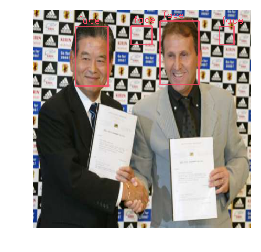

In [92]:
plt.axis("off")
imshow(cv2.cvtColor(boxed_img, cv2.COLOR_BGR2RGB)/255)

In [ ]:
sess.close()